# ПРАКТИКА БУСТИНГ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('AirPass.csv')
df.head(2)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [3]:
df.isnull().sum().sum()

310

Избавимся от пропусков:

In [4]:
df.isnull().sum().sort_values(ascending=False)

Arrival Delay in Minutes             310
Unnamed: 0                             0
Online boarding                        0
Departure Delay in Minutes             0
Cleanliness                            0
Inflight service                       0
Checkin service                        0
Baggage handling                       0
Leg room service                       0
On-board service                       0
Inflight entertainment                 0
Seat comfort                           0
Food and drink                         0
id                                     0
Gate location                          0
Ease of Online booking                 0
Departure/Arrival time convenient      0
Inflight wifi service                  0
Flight Distance                        0
Class                                  0
Type of Travel                         0
Age                                    0
Customer Type                          0
Gender                                 0
satisfaction    

In [5]:
df = df.drop('Unnamed: 0', axis=1)

Все пропуски в одном признаке

In [6]:
df = df.fillna({'Arrival Delay in Minutes': df['Arrival Delay in Minutes'].median()})

In [7]:
round(df['Arrival Delay in Minutes'].mean(),2)

15.13

Посмотрим на распределение признаков связанных с оценкой каких-то элемента полета по полу

In [8]:
#satisfaction_features = list(df.dtypes[df.dtypes != 'object'].index)
#satisfaction_features

In [9]:
#satisfaction_features.remove('id')
#satisfaction_features.remove('Age')
#satisfaction_features.remove('Flight Distance')
#satisfaction_features.remove('Departure Delay in Minutes')
#satisfaction_features.remove('Arrival Delay in Minutes')

In [10]:
#fig, axes = plt.subplots(7,2, figsize = (12,12))
#for i, feature in enumerate(satisfaction_features):
#    sns.boxplot(df, x=feature, y='Gender', ax=axes[i//2][i%2])
#    axes[i//2][i%2].set_title(f'{feature} scoring')
#    axes[i//2][i%2].set_xlabel('')
#    axes[i//2][i%2].set_ylabel('')
    
#plt.tight_layout()    
    

И еще по целевой переменной:

<AxesSubplot: xlabel='satisfaction', ylabel='Gender'>

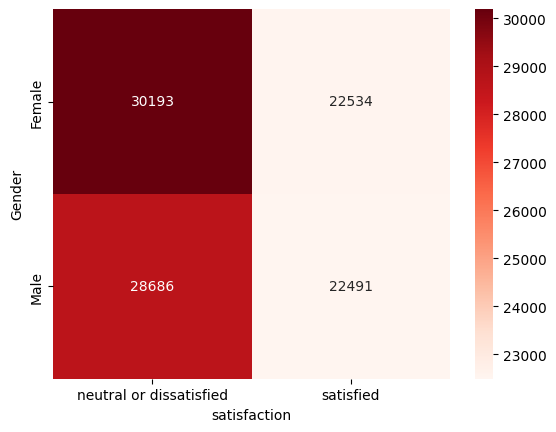

In [11]:
pivot = pd.pivot_table(df,index='Gender',columns='satisfaction', values='id', aggfunc='count')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Reds')

<AxesSubplot: xlabel='satisfaction', ylabel='Type of Travel'>

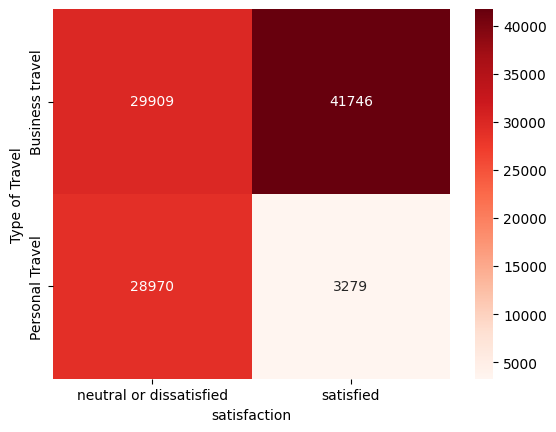

In [12]:
pivot = pd.pivot_table(df,index='Type of Travel',columns='satisfaction', values='id', aggfunc='count')
sns.heatmap(pivot, annot=True, fmt='.0f',cmap='Reds')

<AxesSubplot: xlabel='satisfaction', ylabel='Class'>

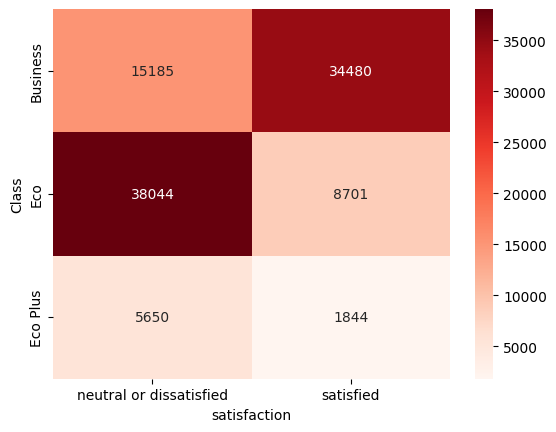

In [13]:
pivot = pd.pivot_table(df,index='Class',columns='satisfaction', values='id', aggfunc='count')
sns.heatmap(pivot, annot=True, fmt='.0f',cmap='Reds')

перекодируем бинарные признаки в числовые

In [14]:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [15]:
df = pd.get_dummies(df)

In [16]:
df.shape

(103904, 26)

Разделим на тренировочный и тестовый наборы

In [17]:
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=26, test_size=0.2)
y_test.shape[0]

20781

Проведем масштабирование

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_test[0][0]

0.9408251379303

Логистическая регерессия

In [20]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_train,y_train)

y_test_pred = LR_model.predict(X_test)
print('LogRegression f1-score on test data =', f1_score(y_test,y_test_pred).round(3))

LogRegression f1-score on test data = 0.855


AdaBoost

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

AB_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=26),
    random_state=26,
    learning_rate=0.01
)

AB_model.fit(X_train,y_train)
y_test_pred = AB_model.predict(X_test)
print('AdaBoost f1-score on test data =', f1_score(y_test,y_test_pred).round(3))

AdaBoost f1-score on test data = 0.94


GradientBoosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

GB_model = GradientBoostingClassifier()
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

GB_best_model = GridSearchCV(
    estimator=GB_model,
    param_grid=params,
    cv=3,
    n_jobs=-1,
    scoring='f1'
)

GB_best_model.fit(X_train,y_train)

y_test_pred = GB_best_model.predict(X_test)
print('Gradient Boosting f1-score on test data =', f1_score(y_test,y_test_pred).round(3))

Gradient Boosting f1-score on test data = 0.951


In [23]:
GB_best_model.best_score_

0.9490976374376325

XGBoost

In [24]:
import xgboost

XGB_model = xgboost.XGBClassifier(random_state = 26)
XGB_model.fit(X_train,y_train)

y_test_pred = XGB_model.predict(X_test)
print('X Gradient Boosting f1-score on test data =', f1_score(y_test,y_test_pred).round(3))

X Gradient Boosting f1-score on test data = 0.958


CatBoost

In [25]:
import catboost

CB_model = catboost.CatBoostClassifier(random_state = 26)
CB_model.fit(X_train,y_train)

y_test_pred = CB_model.predict(X_test)
print('Cat Boost f1-score on test data =', f1_score(y_test,y_test_pred).round(3))

Learning rate set to 0.068023
0:	learn: 0.6018089	total: 172ms	remaining: 2m 51s
1:	learn: 0.5020769	total: 190ms	remaining: 1m 34s
2:	learn: 0.4472481	total: 208ms	remaining: 1m 8s
3:	learn: 0.4028675	total: 225ms	remaining: 56.1s
4:	learn: 0.3674724	total: 247ms	remaining: 49.2s
5:	learn: 0.3397844	total: 267ms	remaining: 44.2s
6:	learn: 0.3121211	total: 286ms	remaining: 40.6s
7:	learn: 0.2917499	total: 307ms	remaining: 38.1s
8:	learn: 0.2749039	total: 324ms	remaining: 35.7s
9:	learn: 0.2575191	total: 336ms	remaining: 33.3s
10:	learn: 0.2473690	total: 351ms	remaining: 31.5s
11:	learn: 0.2377531	total: 365ms	remaining: 30.1s
12:	learn: 0.2279309	total: 382ms	remaining: 29s
13:	learn: 0.2212512	total: 399ms	remaining: 28.1s
14:	learn: 0.2100359	total: 415ms	remaining: 27.3s
15:	learn: 0.2025733	total: 435ms	remaining: 26.7s
16:	learn: 0.1942303	total: 458ms	remaining: 26.5s
17:	learn: 0.1877939	total: 474ms	remaining: 25.8s
18:	learn: 0.1832381	total: 489ms	remaining: 25.2s
19:	learn: 

Матрица ошибок Cat Boost

In [30]:
from catboost.utils import get_confusion_matrix
from catboost import Pool

cm = get_confusion_matrix(CB_model, Pool(X_train, y_train))
print(cm/cm.sum()*100)


[[56.13488445  0.65565487]
 [ 1.53266846 41.67679222]]


Важность признаков

In [33]:
pd.Series( CB_model.feature_importances_, index= X.columns).sort_values(ascending=False)

Inflight wifi service                25.364737
Type of Travel                       18.391876
Online boarding                       7.401483
Customer Type                         7.240564
Class_Business                        5.420057
Checkin service                       3.925791
Age                                   3.742350
Baggage handling                      3.640798
Gate location                         3.196286
Seat comfort                          3.012455
Inflight service                      2.872263
Inflight entertainment                2.839660
id                                    1.958821
Flight Distance                       1.593574
Departure/Arrival time convenient     1.574078
Cleanliness                           1.554563
Ease of Online booking                1.498563
On-board service                      1.482136
Leg room service                      1.217927
Arrival Delay in Minutes              0.835555
Departure Delay in Minutes            0.445704
Food and drin